# Instructions:
You are provided with an Excel file containing the following columns:
1. Referral date
2. Patient ID
3. Referring Physician First Name
4. Referring Physician Last Name

Your task is to perform an analysis of month-wise referring physician status based on the following definition of statuses:

# Referring Physician Status Definitions:

1. **Active**: Physicians who have referred at least one patient in the last 3 months.
2. **Inactive**: Physicians who have not referred any patients in the last 3 months but have referred patients in the past.
3. **New**: Physicians who have referred their first patient.
4. **Reactivated**: Physicians who were previously inactive but have referred patients again in the last 3 months.

# Tasks:
1. Load the provided Excel file into your preferred data analysis tool (e.g., Python, R, etc.).
3. Calculate the referring physician status for each physician based on the provided definitions.
4. Create a summary table or report that shows the count of physicians in each status category for each month.
5. Create a visual representation (e.g., line chart or bar chart) of the monthly status distribution of referring physicians. Each status category should be represented as a different color on the chart.
6. Write a brief analysis (around 100 words) of any interesting insights or trends you observe in the data based on the charts and tables you have created.

# Deliverables:
- Code/script used for data analysis.
- Summary table or report showing the count of physicians in each status category for each month.
- Visual representation (chart) of the monthly status distribution of referring physicians.
- Written analysis of insights and trends.

# Evaluation Criteria:
- Correctness of data analysis.
- Proper data preprocessing and cleaning.
- Accurate calculation of referring physician statuses.
- Creation of clear and visually appealing charts.
- Ability to communicate insights effectively.

# An analysis of month-wise referring physician status

## Status Definitions:

1. **Active**: Physicians who have referred at least one patient in the last 3 months.
2. **Inactive**: Physicians who have not referred any patients in the last 3 months but have referred patients in the past.
3. **New**: Physicians who have referred their first patient.
4. **Reactivated**: Physicians who were previously inactive but have referred patients again in the last 3 months.

### Necessary Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# file_path to read
file_path = "sample file.xlsx"

#### Load the provided Excel file into your preferred data analysis tool (e.g., Python, R, etc.).

In [3]:
df = pd.read_excel(file_path)

In [4]:
# view columns names
df.columns

Index(['referral_date', 'patient id', 'Referred by First Name',
       'Referred by last name'],
      dtype='object')

#### Calculate the referring physician status for each physician based on the provided definitions.

#### Status Definitions:

1. **Active**: Physicians who have referred at least one patient in the last 3 months.
2. **Inactive**: Physicians who have not referred any patients in the last 3 months but have referred patients in the past.
3. **New**: Physicians who have referred their first patient.
4. **Reactivated**: Physicians who were previously inactive but have referred patients again in the last 3 months.

In [5]:
# reconstruct referral date to month and year
df["referral_date"] = df["referral_date"].apply( lambda x : f"{x.month}/{x.year}")

In [6]:
# create a column with full names of rerferrer
df["physician"] = [ f"{first} {last}" for first, last in (zip(df["Referred by First Name"], df["Referred by last name"])) ]

In [7]:
# get a peek at the first 5 rows
df = df[["physician", "referral_date", "patient id"]]
df.head()

,physician,referral_date,patient id
0,Ethan Smith,3/2023,1215
1,Olivia Johnson,3/2023,1154
2,Liam Brown,3/2023,1301
3,Emma Davis,3/2023,1298
4,Noah Miller,10/2022,1165


In [8]:
# physician group
physician_group = df.groupby('physician')

In [9]:
# calculate the referal count for current month
new_df = pd.DataFrame()
for physician_group_name, physician_group_df in physician_group:
    for date_group, date_df in physician_group_df.groupby("referral_date"):
        temp_df = pd.DataFrame({"physician" : [physician_group_name], "referral_date" : [date_group], "referral_count" : [date_df["patient id"].count()]})
        new_df = pd.concat([new_df, temp_df])

In [10]:
# peek at new dataset
new_df.head()

,physician,referral_date,referral_count
0,Abigail Adams,1/2023,1
0,Abigail Adams,2/2023,2
0,Abigail Adams,3/2023,4
0,Abigail Adams,4/2023,3
0,Abigail Adams,5/2023,3


In [11]:
# calculate 3 months referral sum
physician_grouped = new_df.groupby("physician")
master_df_list = []
for physician, physician_df in physician_grouped:
    physician_df = physician_df.reset_index()
    physician_df["referral_sum"] = np.nan
    for i, record in physician_df.iterrows():
        if i >= 2:
            start = i - 2
            end = i + 1
            physician_df.loc[i, "referral_sum"] = physician_df.iloc[start:end]["referral_count"].sum()
        else:
            start = None
            end = i + 1
            physician_df.loc[i, "referral_sum"] = physician_df.iloc[start:end]["referral_count"].sum()
    master_df_list.append(physician_df)

In [12]:
master_df = pd.concat(master_df_list)

In [13]:
# convert column float to int
master_df["referral_sum"] = master_df["referral_sum"].astype(int)

In [14]:
master_df[["Active", "Inactive", "New", "Reactivated"]] = np.nan

In [15]:
master_df = master_df.drop(columns=["index"])

In [16]:
output_df = pd.DataFrame(columns=master_df.columns)
for i, record in master_df.iterrows():
    # iterate each record
    if record["referral_sum"] >=1:
        # Physicians who have referred at least one patient in the last 3 months.
        record["Active"] = 1

    if record["referral_sum"] == 0:
        # Physicians who have not referred any patients in the last 3 months

        # but have referred patients in the past.
        # old records of referred
        if (master_df[master_df['physician'] == record['physician']].iloc[:i]["referral_count"].sum()) >= 1:
            record["Inactive"] = 1

    if (master_df[master_df['physician'] == record['physician']]["referral_count"].sum()) == 1:
        #Physicians who have referred their first patient.
        record["New"] = 1

    if (output_df[output_df['physician'] == record["physician"]]["Inactive"].count() > 0) and (record["referral_sum"] >=1):
        #Physicians who were previously inactive and have referred patients again in the last 3 months.
        record["Reactivated"] = 1
    output_df = pd.concat([output_df, pd.DataFrame([record])])

#### Create a summary table or report that shows the count of physicians in each status category for each month.
#### now we will create a table that is group by months and other columns will be status_count
#### that status count will represent count of physicians status in each month

In [17]:
# this report df will assist in further visualizations.
report_df = pd.DataFrame(columns=["month", 'Active_Count', 'Inactive_Count', 'New_Count', 'Reactivated_Count'])
for month, month_group in output_df.groupby("referral_date"):
    temp_df = pd.DataFrame([{'month' : month, 'Active_Count' : month_group["Active"].count(),
    'Inactive_Count' : month_group["Inactive"].count(),
    'New_Count' : month_group["New"].count(),
    'Reactivated_Count' : month_group["Reactivated"].count()
    }])

    report_df = pd.concat([report_df, temp_df])

In [18]:
report_df["month"] = report_df["month"].apply( lambda x : datetime.strptime(x, '%m/%Y'))
report_df = report_df.sort_values("month")
report_df["month"] = report_df["month"].apply( lambda x : x.strftime("%m/%Y"))

In [19]:
report_df

,month,Active_Count,Inactive_Count,New_Count,Reactivated_Count
0,06/2022,1,0,0,0
0,08/2022,1,0,0,0
0,10/2022,4,0,0,0
0,11/2022,2,0,0,0
0,12/2022,2,0,0,0
0,01/2023,28,0,0,0
0,02/2023,41,0,0,0
0,03/2023,43,0,0,0
0,04/2023,41,0,0,0
0,05/2023,39,0,0,0


#### Create a visual representation (e.g., line chart or bar chart) of the monthly status distribution of referring physicians. Each status category should be represented as a different color on the chart.

In [20]:
plt.figure(figsize=(4, 4))
bar_colors = {
    'Active_Count' : "green", 'Inactive_Count' : "red", 'New_Count' : "blue", 'Reactivated_Count' : "orange"
}

<Figure size 400x400 with 0 Axes>

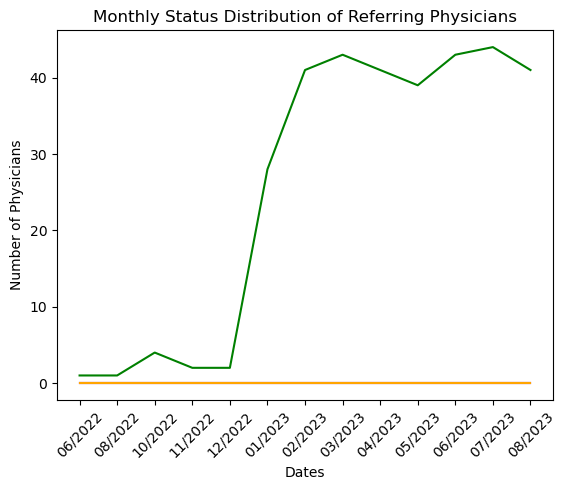

In [21]:
# Here we will render a line plot
# A line plot is a type of graph that displays data points as markers connected by lines. 

plt.xlabel('Dates')
plt.ylabel('Number of Physicians')
plt.title('Monthly Status Distribution of Referring Physicians')

x_row = report_df['month']
y_columns = report_df.columns[1:]

# rotate the dates
plt.xticks(rotation=45)


for col in y_columns:
    plt.plot(x_row, report_df[col], label=col, color=bar_colors[col])

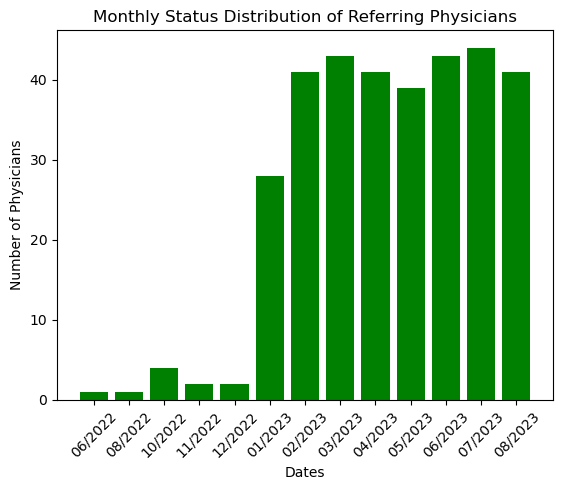

In [22]:
plt.xlabel('Dates')
plt.ylabel('Number of Physicians')
plt.title('Monthly Status Distribution of Referring Physicians')

# rotate the dates
plt.xticks(rotation=45)

for col in y_columns:
    plt.bar(x_row, report_df[col], label=col, color=bar_colors[col])

#### Write a brief analysis (around 100 words) of any interesting insights or trends you observe in the data based on the charts and tables you have created.

Ans:

We have visualize our reporting table and by observing the data points in the Line Plot we can see that the number of active Physician is increasing every month. This trend can easy be seen in the bar graph to. I have use different colors to represent different status count.

In the month of 12/2023 the hipe of suddent Active phyiscians. 
6/2022 and 8/2022 have the same number of active users.
3/2023 having the hightest number of active userss.

In the analysis we can find the number of active users in a certain month to monitors its current status. Through this status we can make our analytical decisions.

The ENE